# Classification - Logistic Regression vs RF or Boosting

<pre>
Goal: show how simple models work on synthetic data
Show that logistic regression is a linear separator
</pre>

In [1]:
import sys, os
import pandas as pd
import numpy as np
import time, glob, re, pickle, itertools, math
import datetime as dt
import IPython

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

import sklearn
import sklearn.metrics as metrics
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

# conda install -c conda-forge xgboost 
import xgboost
from xgboost.sklearn import XGBClassifier

from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from scipy.stats import ks_2samp

%config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.figsize"] = (8, 4) # (width, height)

In [2]:
print('python',sys.version.split()[0])
print('np',np.__version__)
print('pd',pd.__version__)
print('matplotlib',matplotlib.__version__)
print('sklearn',sklearn.__version__)

python 3.9.12
np 1.23.1
pd 1.4.3
matplotlib 3.5.2
sklearn 1.1.1


In [3]:
def sigmoid(t):
    """ sigmoid function - can work on arrays and on individual numbers """
    s = 1.0 / (1.0 + np.exp(-t))
    return s

## Examples with two features x1 & x2 

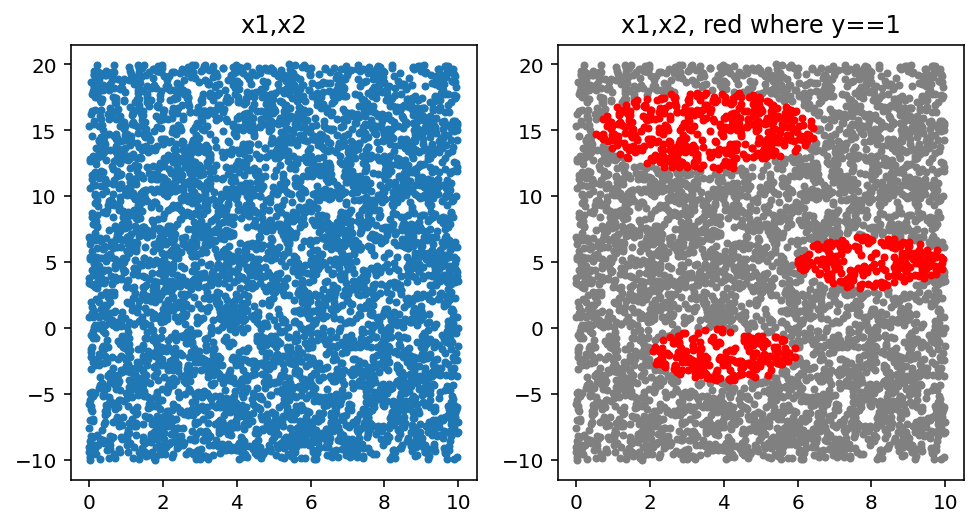

In [4]:
# Let's do example of Logistic Regression 
# with 2 features: x1, x2

N = 5000 # points
rng = np.random.RandomState(seed=1)
x1 = 10 * rng.rand(N)         # random numbers in [0,10] 
x2 = 30 * rng.rand(N) - 10    # random numbers in [-10,20] 
x1 = x1.round(3)
x2 = x2.round(3)
y  = np.zeros(N)
circles = [(3.5,15,3),(8,5,2), (4,-2,2)]

for ii in range(N):
    p1=x1[ii]
    p2=x2[ii]
    for c in circles:
        s1 = (c[0]-p1)**2
        s2 = (c[1]-p2)**2
        dist = math.sqrt(s1+s2)
        if dist < c[2]:
            y[ii] = True
            break

    # if (x1[ii] < 5) and (x2[ii] < 0):
    #     y[ii] = 1

fig,(ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(8, 4)) # (width, height)
_ = ax1.scatter(x1,x2, marker='.')
_ = ax1.set_title("x1,x2")

indices = y == 1
_ = ax2.scatter(x1[~indices], x2[~indices], c = "grey", marker='.')
_ = ax2.scatter(x1[indices], x2[indices], c = 'red', marker='.')
_ = ax2.set_title("x1,x2, red where y==1")
plt.show()

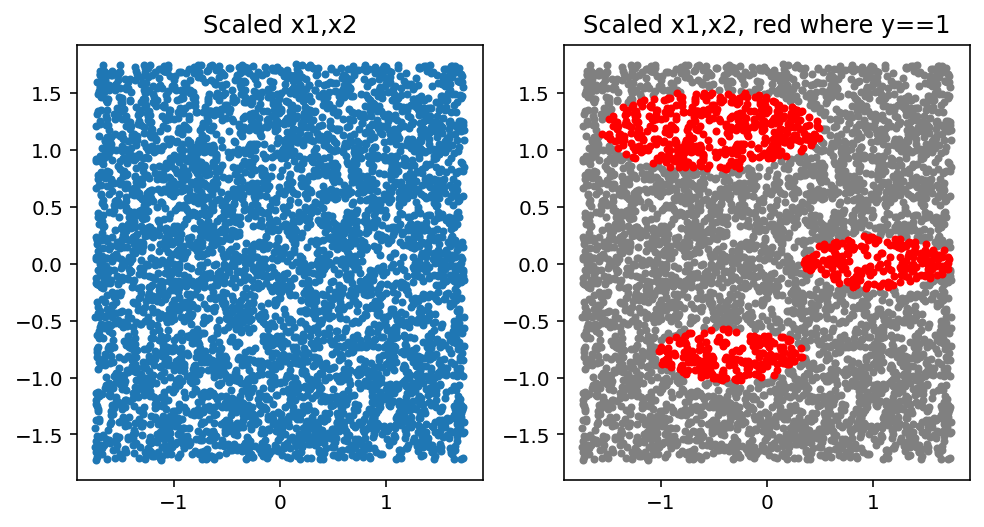

In [5]:
# lets normalize the values of features
data = np.array(list(zip(x1,x2)))
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)
x1 = data_scaled[:,0]
x2 = data_scaled[:,1]
x1 = x1.round(3)
x2 = x2.round(3)

fig,(ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(8, 4)) # (width, height)
_ = ax1.scatter(x1,x2, marker='.')
_ = ax1.set_title("Scaled x1,x2")
indices = y == 1
_ = ax2.scatter(x1[~indices], x2[~indices], c = "grey", marker='.')
_ = ax2.scatter(x1[indices], x2[indices], c = 'red', marker='.')
_ = ax2.set_title("Scaled x1,x2, red where y==1")
plt.show()

In [6]:
%%time
# -------------------------------------- 
# Logistic Regression - 130 ms for 10K points
global model_lr, model_rf, model_xg
model_lr = LogisticRegression(class_weight="balanced", solver='lbfgs', C=10)
print("model_name =",model_lr.__class__.__name__)
model_lr.fit(data, y) 
# --------------------------------------
# RandomForest - 256 ms for 10K points
model_rf = RandomForestClassifier(n_estimators=100) 
print("model_name =",model_rf.__class__.__name__)
model_rf.fit(data, y) 
# --------------------------------------
# XGBoost - 270 ms for 10K points
os.environ['KMP_DUPLICATE_LIB_OK']='True'
params = { 'eta'        : 0.03,
           'objective'  : 'binary:logistic',
           'eval_metric': 'auc',
           'max_depth'  : 15,
           'use_label_encoder' : False
         }
params['eta'] = 0.03
model_xg = XGBClassifier(**params) 
print("model_name =",model_xg.__class__.__name__)
model_xg.fit(data, y) 
print("DONE")

model_name = LogisticRegression
model_name = RandomForestClassifier
model_name = XGBClassifier
DONE
CPU times: user 3.88 s, sys: 1.17 s, total: 5.05 s
Wall time: 1.15 s


In [7]:
predictions = {}
predictions['Actual'] = y
for model in [model_lr,model_rf,model_xg]:
    label = model.__class__.__name__
    print(label)
    yp = model.predict(data)   # predicted on training data
    predictions[label] = yp
    yp = np.array([round(x) for x in yp])
    expected  = y 
    predicted = yp
    print(y[:10])
    print(yp[:10])
    confusion = metrics.confusion_matrix(expected, predicted)
    print(confusion)
    print("-"*40)

LogisticRegression
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
[1 1 0 1 0 1 0 0 0 1]
[[2265 1840]
 [ 445  450]]
----------------------------------------
RandomForestClassifier
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
[0 0 0 0 0 0 0 0 0 1]
[[4105    0]
 [   0  895]]
----------------------------------------
XGBClassifier
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
[0 0 0 0 0 0 0 0 0 1]
[[4104    1]
 [   0  895]]
----------------------------------------


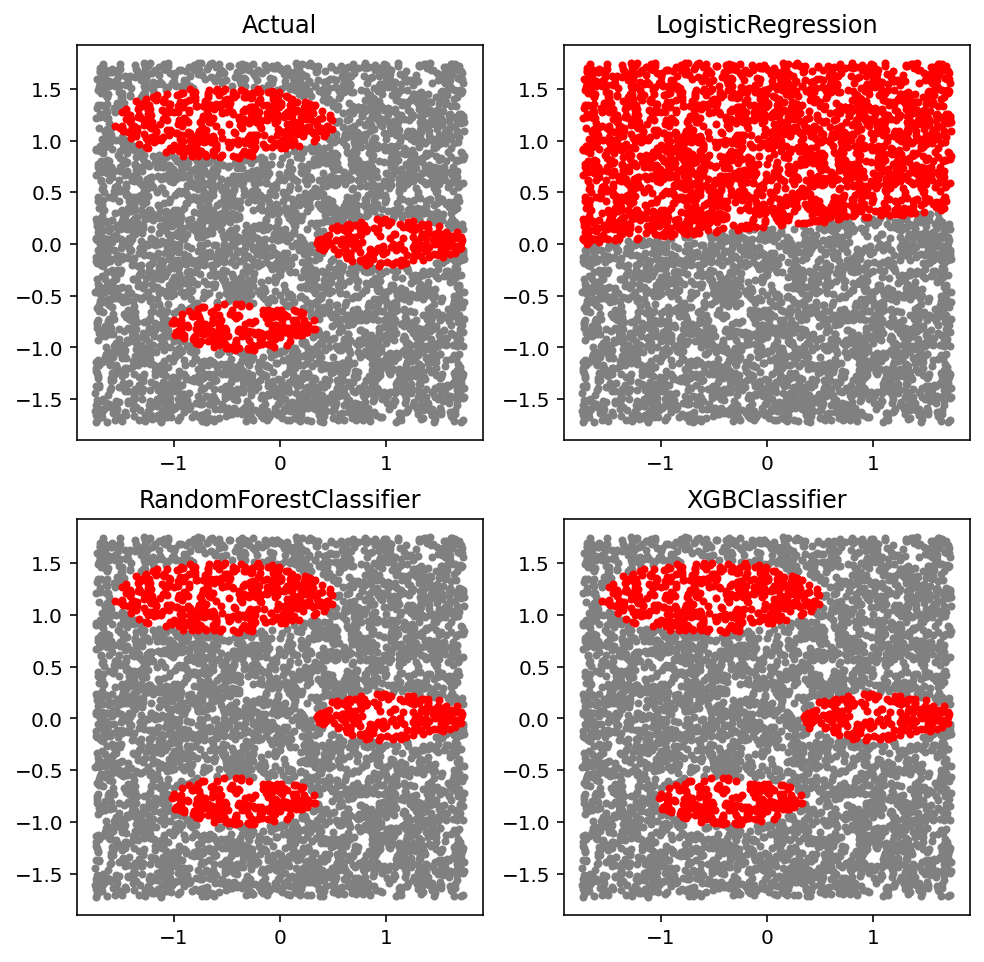

In [8]:
fig,ax = plt.subplots(nrows=2, ncols=2, figsize=(8, 8)) # (width, height)
ax1,ax2,ax3,ax4 = ax.flatten()

labels = ['Actual','LogisticRegression','RandomForestClassifier','XGBClassifier']
axlist = [ax1,ax2,ax3,ax4]
for ii in range(len(axlist)):
    label = labels[ii]
    axx = axlist[ii]
    yy = predictions[label]
    ind_data = yy > 0.5
    _ = axx.scatter(x1[~ind_data], x2[~ind_data], c = "grey", marker='.')
    _ = axx.scatter(x1[ind_data], x2[ind_data], c = 'red', marker='.')
    _ = axx.set_title(label)

plt.show();

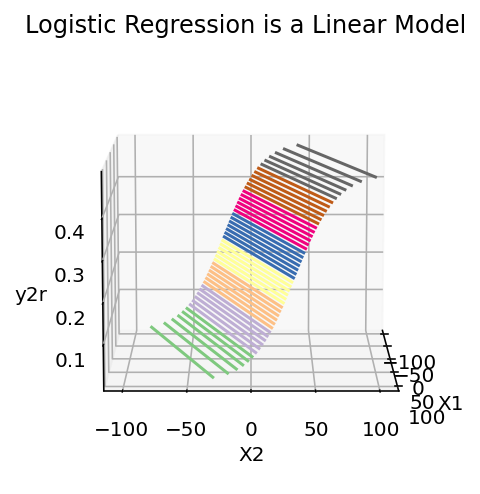

In [9]:
# Make a 3D graph for LogisticRegression
a1 = model_lr.coef_[0][0] 
a2 = model_lr.coef_[0][1]
b = model_lr.intercept_[0]

n = 100
N = 100
x1r = np.linspace(-N, N, n, dtype=float) 
x2r = np.linspace(-N, N, n, dtype=float) 
y2r = np.zeros((n,n))
for i1 in range(n):
    for i2 in range(n):
            y2r[i1,i2] = 0.5*sigmoid(b + a1*x1r[i1] + a2*x2r[i2])

_X1, _X2 = np.meshgrid(x1r, x2r, indexing='ij')
# ----------------------------------------------
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(_X1, _X2, y2r, 50, 
             cmap=cm.Accent
            )
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('y2r');
ax.view_init(elev=10, azim=0, vertical_axis='z') 

_ = ax.set_title("Logistic Regression is a Linear Model")
plt.show();